In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Semantic-Segmentation')

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle

import utils, augment, models

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [4]:
## read data from tfrecords files
def map_func(example):
    image, label = utils.parse_example(example)
    return augment.resize_with_pad(image, label) # no dataset augmentation

train_dataset = tf.data.TFRecordDataset('data/train.tfrecords').map(map_func)
val_dataset = tf.data.TFRecordDataset('data/val.tfrecords').map(map_func)

In [5]:
## check data
for X, y in train_dataset.shuffle(20).take(1):
    plt.figure()
    plt.imshow(X)
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(y))
    plt.show()

# **Model**

In [6]:
## VGG16 base model
base_model = models.vgg16(l2=1e-6, dropout=0.2)

In [7]:
## Load ImageNet weights
## https://keras.io/api/applications/
vgg16 = keras.applications.vgg16.VGG16(weights='imagenet')
weight_list = vgg16.get_weights()
weight_list[26] = weight_list[26].reshape(7, 7, 512, 4096)
weight_list[28] = weight_list[28].reshape(1, 1, 4096, 4096)
weight_list[30] = weight_list[30].reshape(1, 1, 4096, 1000)
base_model.set_weights(weight_list)
del weight_list

553476096/553467096 [==============================] - 4s 0us/step


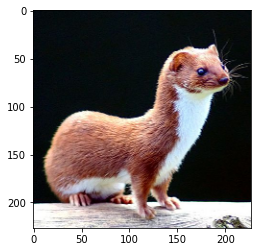

Top three guesses with probabilities:
weasel (p=0.791)
mink (p=0.103)
polecat, fitch, foulmart, foumart, Mustela putorius (p=0.103)


In [8]:
## Test base model
from class_names.imagenet import class_names

img = utils.get_image('assets/laska.png')
plt.figure()
plt.imshow(img)
plt.show()

print('Top three guesses with probabilities:')
probs = base_model.predict(img[None])[0, 3, 3] # pick the central prediction from 7 x 7 square
pred = np.argsort(probs)[::-1]
for i in range(3):
    c = pred[i]
    print("{0:s} (p={1:.3f})".format(class_names[c], probs[c]))

In [9]:
## FCN32
fcn32 = models.fcn32(base_model, l2=1e-6)
# ## freeze lower layers for fine-tuning
# fcn32.get_layer('block1_conv1').trainable=False
# fcn32.get_layer('block1_conv2').trainable=False
# fcn32.get_layer('block2_conv1').trainable=False
# fcn32.get_layer('block2_conv2').trainable=False
# fcn32.get_layer('block3_conv1').trainable=False
# fcn32.get_layer('block3_conv2').trainable=False
# fcn32.get_layer('block3_conv3').trainable=False
# fcn32.get_layer('block4_conv1').trainable=False
# fcn32.get_layer('block4_conv2').trainable=False
# fcn32.get_layer('block4_conv3').trainable=False
## freeze upsample layer
fcn32.get_layer('fcn32').trainable=False

In [10]:
## Load weights, if trained
fcn32.load_weights('weights/fcn32_25.h5')

OSError: ignored

In [ ]:
## FCN16
fcn16 = models.fcn16(base_model, fcn32, l2=1e-6)
# ## unfreeze layers
# fcn16.get_layer('block4_conv1').trainable=True
# fcn16.get_layer('block4_conv2').trainable=True
# fcn16.get_layer('block4_conv3').trainable=True
## freeze upsample layer
fcn16.get_layer('score7_upsample').trainable=False
fcn16.get_layer('fcn16').trainable=False

In [ ]:
## Load weights, if trained
fcn16.load_weights('weights/fcn16_25.h5')

In [ ]:
## FCN8
fcn8 = models.fcn8(base_model, fcn16, l2=1e-6)
# ## unfreeze layers
# fcn8.get_layer('block1_conv1').trainable=True
# fcn8.get_layer('block1_conv2').trainable=True
# fcn8.get_layer('block2_conv1').trainable=True
# fcn8.get_layer('block2_conv2').trainable=True
# fcn8.get_layer('block3_conv1').trainable=True
# fcn8.get_layer('block3_conv2').trainable=True
# fcn8.get_layer('block3_conv3').trainable=True
## freeze upsample layer
fcn8.get_layer('skip4_upsample').trainable=False
fcn8.get_layer('fcn8').trainable=False

In [ ]:
## Load weights, if trained
fcn8.load_weights('weights/fcn8_25.h5')

# **Training**

In [11]:
## Load model
model = fcn32
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, None, 3)]   0         
                                                                 
 preprocessing (Lambda)      (None, None, None, 3)     0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   1475

In [12]:
## compile
opt = keras.optimizers.Adam(learning_rate=1e-4)
loss = models.crossentropy
metrics = [loss,
           models.pixelacc,
           models.MyMeanIoU(num_classes=21, name='meanIoU')]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [13]:
## test model
for X, y in val_dataset.shuffle(100).batch(1).take(1):
    plt.figure()
    plt.imshow(X[0])
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(y[0]))
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(utils.onehot_to_label(model(X)[0])))
    plt.show()
    
    model.evaluate(X, y)

In [14]:
## check running GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [15]:
## training and validation datasets
train = train_dataset.shuffle(1000).batch(16)
val = val_dataset.shuffle(1000).batch(16)

In [16]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5


ValueError: ignored

In [ ]:
## Save weights and metrics

model.save_weights('weights/fcn32_5.h5')

with open('logs/fcn32_5', 'wb') as f:
    pickle.dump(history.history, f)

# **Evaluate**

In [ ]:
from PIL import Image

In [ ]:
raw_X = utils.get_image('assets/rider.jpg')
raw_y_true = utils.get_label_mat('assets/rider_label.mat')

In [ ]:
X, y_true = augment.resize_with_pad(raw_X, raw_y_true)
y_pred = model(X[None])[0]
_ = model.evaluate(X[None], y_true[None])

In [ ]:
raw_y_pred = tf.image.resize_with_crop_or_pad(y_pred, raw_y_true.shape[0], raw_y_true.shape[1])
raw_y_pred = utils.onehot_to_label(raw_y_pred)

In [ ]:
plt.figure()
plt.imshow(utils.label_to_image(raw_y_true))
plt.show()

plt.figure()
plt.imshow(utils.label_to_image(raw_y_pred))
plt.show()

In [ ]:
## save pred label
im = Image.fromarray(utils.label_to_image(raw_y_pred))
im.save('assets/fcn32.png')

In [ ]:
## save true label
im = Image.fromarray(utils.label_to_image(raw_y_true))
im.save('assets/rider_label.png')

# **Plot**

In [ ]:
## aggregate data if needed
with open('logs/fcn32_5', 'rb') as f:
    h1 = pickle.load(f)
with open('logs/fcn32_10', 'rb') as f:
    h2 = pickle.load(f)
with open('logs/fcn32_15', 'rb') as f:
    h3 = pickle.load(f)
with open('logs/fcn32_20', 'rb') as f:
    h4 = pickle.load(f)
with open('logs/fcn32_25', 'rb') as f:
    h5 = pickle.load(f)
    
for key in h1:
    h1[key] += h2[key]
    h1[key] += h3[key]
    h1[key] += h4[key]
    h1[key] += h5[key]
    
with open('logs/fcn32_25x', 'wb') as f:
    pickle.dump(h1, f)

In [ ]:
with open('logs/fcn32_25', 'rb') as f:
    h1 = pickle.load(f)
with open('logs/fcn16_25', 'rb') as f:
    h2 = pickle.load(f)
with open('logs/fcn8_25', 'rb') as f:
    h3 = pickle.load(f)

In [ ]:
plt.plot(range(1,26), h1['val_loss'], '-', color='blue', label='FCN32 validation loss')
plt.plot(range(1,26), h1['loss'], '--', color='blue', label='FCN32 training loss')
plt.plot(range(1,26), h2['val_loss'], '-', color='red', label='FCN16 validation loss')
plt.plot(range(1,26), h2['loss'], '--', color='red', label='FCN16 training loss')
plt.plot(range(1,26), h3['val_loss'], '-', color='green', label='FCN8 validation loss')
plt.plot(range(1,26), h3['loss'], '--', color='green', label='FCN8 training loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(1,26), h1['val_meanIoU'], '-', color='blue', label='FCN32 validation meanIoU')
plt.plot(range(1,26), h1['meanIoU'], '--', color='blue', label='FCN32 training meanIoU')
plt.plot(range(1,26), h2['val_meanIoU'], '-', color='red', label='FCN16 validation meanIoU')
plt.plot(range(1,26), h2['meanIoU'], '--', color='red', label='FCN16 training meanIoU')
plt.plot(range(1,26), h3['val_meanIoU'], '-', color='green', label='FCN8 validation meanIoU')
plt.plot(range(1,26), h3['meanIoU'], '--', color='green', label='FCN8 training meanIoU')
plt.legend()
plt.show()

In [ ]:
print('fcn32 pixel acc: {0:.3f}'.format(h1['val_pixelacc'][-1]))
print('fcn16 pixel acc: {0:.3f}'.format(h2['val_pixelacc'][-1]))
print('fcn8 pixel acc: {0:.3f}'.format(h3['val_pixelacc'][-1]))
print()
print('fcn32 val meanIoU: {0:.3f}'.format(h1['val_meanIoU'][-1]))
print('fcn16 val meanIoU: {0:.3f}'.format(h2['val_meanIoU'][-1]))
print('fcn8 val meanIoU: {0:.3f}'.format(h3['val_meanIoU'][-1]))